In [1]:
import sys
!python --version
import numpy as np
import xarray as xr
import itertools as it
import multiprocessing as mp
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.rcsetup as rcsetup
import tensorflow as tf
import sklearn
from keras.layers import *
from keras.regularizers import l1,l2
from keras.models import Model
from livelossplot.keras import PlotLossesCallback

CPU_COUNT = mp.cpu_count()
print('{} CPUs'.format(CPU_COUNT))
print('numpy version: {}'.format(np.__version__))
print('xarray version: {}'.format(xr.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('sklearn version: {}'.format(sklearn.__version__))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Python 3.7.1


Using TensorFlow backend.


8 CPUs
numpy version: 1.15.4
xarray version: 0.11.3
matplotlib version: 3.0.2
sklearn version: 0.20.1


In [2]:
X_ccsm4 = xr.open_dataset('data/rcp26/CCSM4/rcp26_CCSM4_grid.nc')
X_cesm = xr.open_dataset('data/rcp26/CESM1-CAM5/rcp26_CESM1-CAM5_grid.nc')
X_canesm = xr.open_dataset('data/rcp26/CanESM2/rcp26_CanESM2_grid.nc')
X_cnrm = xr.open_dataset('data/rcp26/CNRM-CM5/rcp26_CNRM-CM5_grid.nc')
X_miroc5 = xr.open_dataset('data/rcp26/MIROC5/rcp26_MIROC5_grid.nc')
X_all = [X_ccsm4.to_array().values, X_cesm.to_array().values, X_canesm.to_array().values, X_cnrm.to_array().values, X_miroc5.to_array().values]

N_lat = 72
N_lon = 144

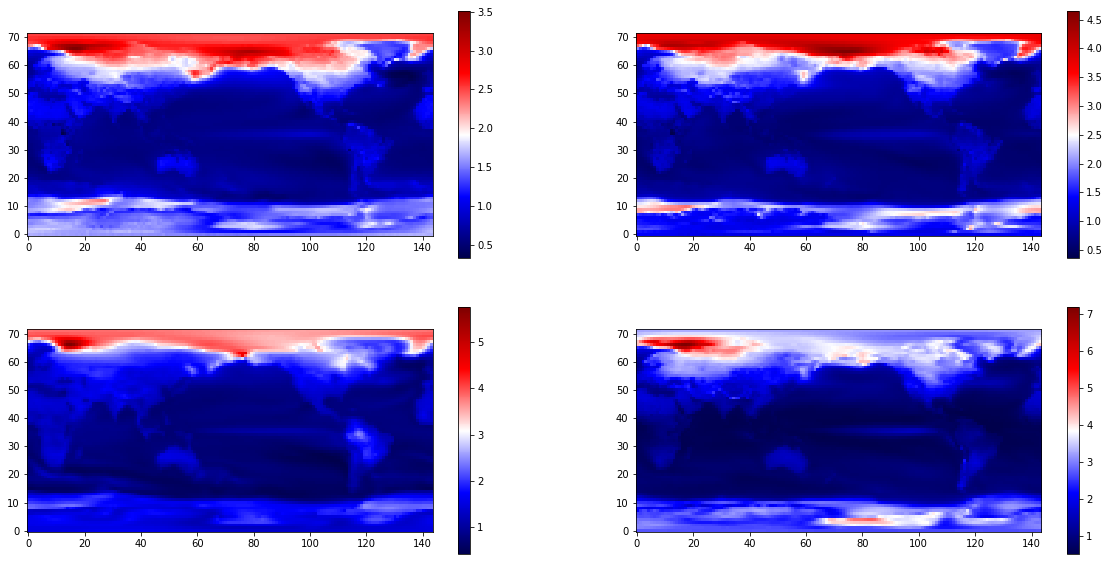

In [3]:
plt.figure(figsize=(20,10))
stdev = X_ccsm4.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,1)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
stdev = X_cesm.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,2)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
stdev = X_canesm.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,3)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
stdev = X_cnrm.std(dim='time').to_array().values.reshape((72, 144))
plt.subplot(2,2,4)
plt.imshow(stdev, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [4]:
BATCH_SIZE = int(X_flat.shape[0] / 10)

input_0 = Input(batch_shape=(BATCH_SIZE, X_flat.shape[1]))
dense_1 = Dense(32, activation='relu', kernel_regularizer=l1(1.0e-5))(input_0)
dense_3 = Dense(X_flat.shape[1], activation='linear')(dense_1)

model = Model(inputs=input_0, outputs=dense_3)
model.compile(optimizer='adam', loss='mse')

NameError: name 'X_flat' is not defined

In [ ]:
from livelossplot.keras import PlotLossesCallback

model.fit(X_flat, X_flat, batch_size=BATCH_SIZE, epochs=50, callbacks=[PlotLossesCallback()])

### Convolutional model

In [25]:
BATCH_SIZE = 5*144

input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, 1))
conv_0 = Conv2D(18, (3,4), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(12, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = Conv2D(9, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_1))
wta = MaxPooling2D((9,9))(conv_2) # pool over entire image

upsampled_wta = UpSampling2D((3,3))(Reshape((3,3,1))(wta))
conv_4 = Conv2D(9, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(upsampled_wta))
conv_5 = Conv2D(12, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(conv_4))
conv_6 = Conv2D(18, (3,4), activation='relu', padding='same')(UpSampling2D((2,4))(conv_5))
conv_7 = Conv2D(1, (3,3), padding='same')(conv_6)
conv_model = Model(inputs=input_0, outputs=conv_7)

conv_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (720, 72, 144, 1)         0         
_________________________________________________________________
batch_normalization_31 (Batc (720, 72, 144, 1)         4         
_________________________________________________________________
conv2d_52 (Conv2D)           (720, 36, 36, 9)          117       
_________________________________________________________________
batch_normalization_32 (Batc (720, 36, 36, 9)          36        
_________________________________________________________________
conv2d_53 (Conv2D)           (720, 18, 18, 9)          738       
_________________________________________________________________
batch_normalization_33 (Batc (720, 18, 18, 9)          36        
_________________________________________________________________
conv2d_54 (Conv2D)           (720, 9, 9, 9)            738       
__________

In [26]:
X_all_t = list(map(lambda x: np.transpose(x, axes=[1,2,3,0]), X_all))
print(X_all_t[0].shape)
X_stacked = np.hstack(X_all_t).reshape((len(X_all_t)*X_all_t[0].shape[0], N_lat, N_lon, 1))
print(X_stacked.shape)

(2880, 72, 144, 1)
(14400, 72, 144, 1)


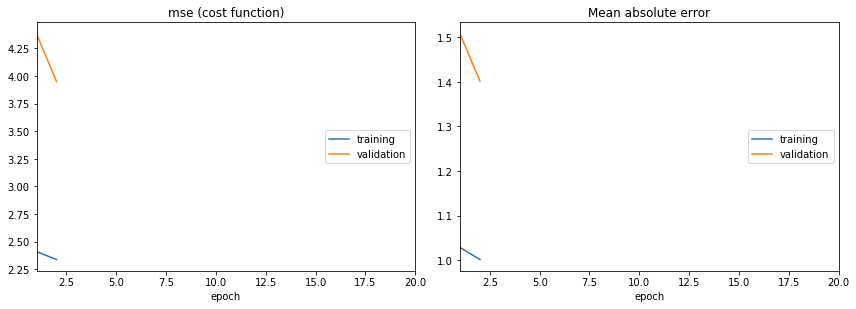

mse (cost function):
training   (min:    2.339, max:    2.410, cur:    2.339)
validation (min:    3.950, max:    4.381, cur:    3.950)

Mean absolute error:
training   (min:    1.002, max:    1.029, cur:    1.002)
validation (min:    1.402, max:    1.508, cur:    1.402)
Epoch 3/20
 4320/11520 [==========>...................] - ETA: 30s - loss: 2.3095 - mean_absolute_error: 0.9917

KeyboardInterrupt: 

In [27]:
conv_model.fit(X_stacked, X_stacked, batch_size=BATCH_SIZE, epochs=20, shuffle=True, validation_split=0.2, callbacks=[PlotLossesCallback()])

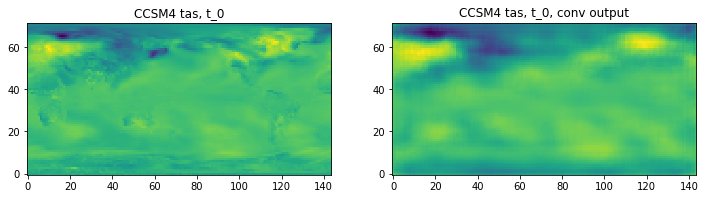

In [11]:
X_ccsm4_t0 = X_ccsm4.to_array().values.reshape((2880, 72, 144))[0,:,:]
X_pred = conv_model.predict(X_ccsm4_t0.reshape((1,72,144,1))).reshape((72,144))
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(X_ccsm4_t0, origin='lower')
plt.title("CCSM4 tas, t_0")
plt.subplot(1,2,2)
plt.imshow(X_pred, origin='lower')
plt.title("CCSM4 tas, t_0, conv output")
plt.show()

(2880, 72, 144, 1)


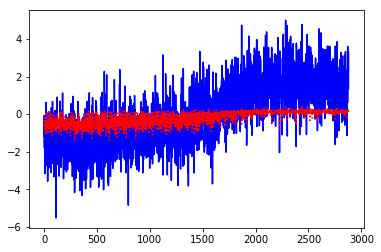

In [12]:
X_orig = X_ccsm4.to_array().values.reshape((2880,72,144,1))
X_pred = conv_model.predict_on_batch(X_orig)
print(X_pred.shape)
plt.plot(range(X_orig.shape[0]), X_orig[:,0,0,0], c='blue')
plt.plot(range(X_orig.shape[0]), X_pred[:,0,0,0], ':', c='red')
plt.show()

### Convolutional LSTM model

In [15]:
BATCH_SIZE = 1

N_time = 2880
input_0 = Input(batch_shape=(BATCH_SIZE, N_time, N_lat, N_lon, 1))
conv_0 = ConvLSTM2D(16, (3,3), strides=(2,4), return_sequences=True, activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = ConvLSTM2D(8, (3,3), strides=(2,2), return_sequences=True, activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = ConvLSTM2D(4, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_1))

reshape_in = Reshape((9*9*4,))
repeat = RepeatVector(N_time)(reshape_in(conv_2))
reshape_out = Reshape((N_time, 9, 9, 4))(repeat)
conv_4 = ConvLSTM2D(4, (3,3), return_sequences=True, activation='relu', padding='same')(TimeDistributed(UpSampling2D((2,2)))(reshape_out))
conv_5 = ConvLSTM2D(8, (3,3), return_sequences=True, activation='relu', padding='same')(TimeDistributed(UpSampling2D((2,2)))(conv_4))
conv_6 = ConvLSTM2D(16, (3,3), return_sequences=True, activation='relu', padding='same')(TimeDistributed(UpSampling2D((2,4)))(conv_5))
conv_7 = ConvLSTM2D(1, (3,3), return_sequences=True, padding='same')(conv_6)
conv_model = Model(inputs=input_0, outputs=conv_7)

conv_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (1, 2880, 72, 144, 1)     0         
_________________________________________________________________
batch_normalization_16 (Batc (1, 2880, 72, 144, 1)     4         
_________________________________________________________________
conv_lst_m2d_21 (ConvLSTM2D) (1, 2880, 36, 36, 16)     9856      
_________________________________________________________________
batch_normalization_17 (Batc (1, 2880, 36, 36, 16)     64        
_________________________________________________________________
conv_lst_m2d_22 (ConvLSTM2D) (1, 2880, 18, 18, 8)      6944      
_________________________________________________________________
batch_normalization_18 (Batc (1, 2880, 18, 18, 8)      32        
_________________________________________________________________
conv_lst_m2d_23 (ConvLSTM2D) (1, 9, 9, 4)              1744      
__________

In [ ]:
conv_model.fit(X_all, X_all, epochs=20, callbacks=[PlotLossesCallback()])

### Variational autoencoder

In [22]:
BATCH_SIZE = 4*144

input_0 = Input(batch_shape=(BATCH_SIZE, N_lat, N_lon, 1))
conv_0 = Conv2D(16, (6,6), strides=(2,4), activation='relu', padding='same')(BatchNormalization()(input_0))
conv_1 = Conv2D(8, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_0))
conv_2 = Conv2D(4, (3,3), strides=(2,2), activation='relu', padding='same')(BatchNormalization()(conv_1))

latent_dims = 4*9*9
epsilon_std = 1
z_mean = Dense(latent_dims)(Flatten()(conv_2))
z_log_sigma = Dense(latent_dims)(Flatten()(conv_2))
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(BATCH_SIZE, latent_dims), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon
z = Lambda(sampling)([z_mean, z_log_sigma])

reshaped = Reshape((9, 9, 4))(z)
conv_4 = Conv2D(4, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(reshaped))
conv_5 = Conv2D(8, (3,3), activation='relu', padding='same')(UpSampling2D((2,2))(conv_4))
conv_6 = Conv2D(16, (6,6), activation='relu', padding='same')(UpSampling2D((2,4))(conv_5))
conv_7 = Conv2D(1, (3,3), padding='same')(conv_6)
vae_model = Model(inputs=input_0, outputs=conv_7)

vae_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(vae_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (576, 72, 144, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (576, 72, 144, 1)    4           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (576, 36, 36, 16)    592         batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (576, 36, 36, 16)    64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 